## Run me on colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rjlopez2/ADS_CAS_Bern_2020/blob/main/Projects/M1%20and%20M2/M1_cas_data_science.ipynb#scrollTo=5OdD3sEbOX1J)


### **Import libraries**

In [532]:
import pandas as pd
#!pip install wget # uncomment this igf you run it via colab
import os
from zipfile import ZipFile
import numpy as np
import wget
import requests
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

# Part I 
# M1 project 

## On data aquisition, formating and cleaning

## 1. John Hopkins data collection and cleaning
### **Download the time series datasets on global Covid cases from the John Hpkins University**
The time series are organized in 3 different files from their Github repository:

 - one file retrieve information on the confirmed cases
 - one file retrieve information on the death cases
 - one file retrieve information on the recovered cases

Below we download the 3 datastes and store them locally in .csv format.

In [533]:
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

path = os.getcwd() # get the current directory

for url in urls:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [534]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

### **We explore below the structure of the 3 datasets**

By looking at the shape of the 3 df, we observe that the recovered_df has different dimention than the two others.
Closer inspection revealed that 14 provinces from Canada were missed in the recovered_df.

In [535]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(267, 269), (267, 269), (254, 269)]


In [536]:
confirmed_df[~confirmed_df['Province/State'].isin(recovered_df['Province/State'])][['Province/State', 'Country/Region']] # !!! 14 'Province/State'  no found in the recovered_df

Province/State Country/Region
39                    Alberta         Canada
40           British Columbia         Canada
41           Diamond Princess         Canada
42             Grand Princess         Canada
43                   Manitoba         Canada
44              New Brunswick         Canada
45  Newfoundland and Labrador         Canada
46      Northwest Territories         Canada
47                Nova Scotia         Canada
48                    Ontario         Canada
49       Prince Edward Island         Canada
50                     Quebec         Canada
51               Saskatchewan         Canada
52                      Yukon         Canada

Because of this inconsistency, we decided to exclude data from Canada for now.

In [537]:
recovered_df = recovered_df[recovered_df['Country/Region']!='Canada']
confirmed_df = confirmed_df[confirmed_df['Country/Region']!='Canada']
deaths_df = deaths_df[deaths_df['Country/Region']!='Canada']

In [538]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(253, 269), (253, 269), (253, 269)]


We observed that the first 4 colums of each dataset have the same variables so we use them to merge all 3 datasets and we define the time variable with the rest of the colums

1. We create the vector for the time varibale
2. we transform the 3 dataframes to long format. 

In [539]:
recovered_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/3/20', '10/4/20', '10/5/20', '10/6/20', '10/7/20', '10/8/20',
       '10/9/20', '10/10/20', '10/11/20', '10/12/20'],
      dtype='object', length=269)

In [540]:
deaths_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/3/20', '10/4/20', '10/5/20', '10/6/20', '10/7/20', '10/8/20',
       '10/9/20', '10/10/20', '10/11/20', '10/12/20'],
      dtype='object', length=269)

In [541]:
confirmed_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/3/20', '10/4/20', '10/5/20', '10/6/20', '10/7/20', '10/8/20',
       '10/9/20', '10/10/20', '10/11/20', '10/12/20'],
      dtype='object', length=269)

In [542]:
dates = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths')

recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [543]:
# check the size of each dataset in long format
print([confirmed_df_long.shape, deaths_df_long.shape, recovered_df_long.shape])

[(67045, 6), (67045, 6), (67045, 6)]


In [544]:
# check if the number of countries are the same in each subset
print(confirmed_df_long['Country/Region'].drop_duplicates().shape, 
      deaths_df_long['Country/Region'].drop_duplicates().shape, 
      recovered_df_long['Country/Region'].drop_duplicates().shape)
      

(188,) (188,) (188,)


In [545]:
# Merge the 3 datasets 

confirmed_df_long["Deaths"] = deaths_df_long["Deaths"]
confirmed_df_long["Recovered"] = recovered_df_long['Recovered']
full_table = confirmed_df_long

In [546]:
full_table.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67045 entries, 0 to 67044
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  17755 non-null  object 
 1   Country/Region  67045 non-null  object 
 2   Lat             67045 non-null  float64
 3   Long            67045 non-null  float64
 4   Date            67045 non-null  object 
 5   Confirmed       67045 non-null  int64  
 6   Deaths          67045 non-null  int64  
 7   Recovered       67045 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 4.1+ MB


In [547]:
# trasnform from string to date the "Date" column
full_table['Date'] = pd.to_datetime(full_table['Date'])

### **Check and fix NaN in the full dataset**

In [548]:
full_table.isna().sum()

Province/State    49290
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

### **Remove cruise ships data**
 #### We also observed that there is some of confirmed cases of Covid from the cruise ships (Grand Princess, Diamond Princess and MS Zaandam) that make it difficult to fit in in the Country category, so we excluded from our anaysis

In [549]:
# select the ships rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

In [550]:
full_table = full_table[~(ship_rows)] # the '~' operator negate the selections

## **Add new colum for active cases**
Below we compute the active cases by substracting the number of death and recovered to the confirmed cases.

In [551]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table

/Users/rubencito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Province/State      Country/Region        Lat       Long       Date  \
0                NaN         Afghanistan  33.939110  67.709953 2020-01-22   
1                NaN             Albania  41.153300  20.168300 2020-01-22   
2                NaN             Algeria  28.033900   1.659600 2020-01-22   
3                NaN             Andorra  42.506300   1.521800 2020-01-22   
4                NaN              Angola -11.202700  17.873900 2020-01-22   
...              ...                 ...        ...        ...        ...   
67040            NaN  West Bank and Gaza  31.952200  35.233200 2020-10-12   
67041            NaN      Western Sahara  24.215500 -12.885800 2020-10-12   
67042            NaN               Yemen  15.552727  48.516388 2020-10-12   
67043            NaN              Zambia -13.133897  27.849332 2020-10-12   
67044            NaN            Zimbabwe -19.015438  29.154857 2020-10-12   

       Confirmed  Deaths  Recovered  Active  
0              0       0          0       0  
1              0       0          0       0  
2              0       0          0       0  
3              0       0          0       0  
4              0       0          0       0  
...          ...     ...        ...     ...  
67040      44684     387      38228    6069  
67041         10       1          8       1  
67042       2052     596       1329     127  
67043      15549     345      14682     522  
67044       8021     230       7627     164  

[66515 rows x 9 columns]

We agregate the data by Country and Date (by means of grouping) and calculate de sum of the cases

In [552]:
full_grouped = full_table.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

full_grouped

Date      Country/Region  Confirmed  Deaths  Recovered  Active
0     2020-01-22         Afghanistan          0       0          0       0
1     2020-01-22             Albania          0       0          0       0
2     2020-01-22             Algeria          0       0          0       0
3     2020-01-22             Andorra          0       0          0       0
4     2020-01-22              Angola          0       0          0       0
...          ...                 ...        ...     ...        ...     ...
49285 2020-10-12  West Bank and Gaza      44684     387      38228    6069
49286 2020-10-12      Western Sahara         10       1          8       1
49287 2020-10-12               Yemen       2052     596       1329     127
49288 2020-10-12              Zambia      15549     345      14682     522
49289 2020-10-12            Zimbabwe       8021     230       7627     164

[49290 rows x 6 columns]

## Add new column(s) for new cases / new deaths / new recovered

In [553]:
# new cases 
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New_cases', 'New_deaths', 'New_recovered']

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New_cases', 'New_deaths', 'New_recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

# 
full_grouped['New_cases'] = full_grouped['New_cases'].apply(lambda x: 0 if x<0 else x)

/Users/rubencito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [554]:
#rename the "Country/Region" variable
full_grouped.rename(columns = {'Country/Region' : 'Country_Region'}, inplace = True)


In [555]:
# compute the number of countries registered in the covide dataset
full_grouped['Country_Region'].unique().size

186

## **Extract metadata for Covid datasets**
We want to merge the covid dataset with other datasets by a comun variable, in our case is the Country. To make sure that the union of datasets are compatible, and since countries might be named disticntly  from each dataset source we use the country code as an standard varibale fro later merge. Now we asign to the Covid dataframe a new colum for the Country codes. To achieve this task we do the following steps: 
 - Load metadata from the Covid repository
 - Extract the information on Country code (here is the variable called 'iso3')

We also extract additional information on the population from each country. this will be used later for normalizing our variables.

In [556]:
covid_metadata_countries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv",
                                      usecols = ['Country_Region', 'Province_State', 'iso3', 'Population'])


In [557]:
covid_metadata_countries.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4154 entries, 0 to 4153
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso3            4152 non-null   object 
 1   Province_State  3965 non-null   object 
 2   Country_Region  4154 non-null   object 
 3   Population      4013 non-null   float64
dtypes: float64(1), object(3)
memory usage: 129.9+ KB


### **Remove the cruise ships information from the metadata on country codes**

In [558]:
# select from columns 'Country_Region' the names 'Diamond Princess'and 'MS Zaandam'
ship_metadata = covid_metadata_countries['Country_Region'].str.contains('Diamond Princess') | covid_metadata_countries['Country_Region'].str.contains('MS Zaandam')
ship_metadata
covid_metadata_countries = covid_metadata_countries[~(ship_metadata)]

### **Summarize the population by country in the metadata dataframe**

In [559]:
#my_covid_variables = ['Confirmed', 'Deaths', 'Recovered', 'Active']
code_vars = ['Country_Region', 'iso3']

#full_table.groupby(['Date', 'Country/Region'])[my_covid_variables].sum().reset_index()
country_population = covid_metadata_countries.groupby(code_vars)['Population'].sum().reset_index()

In [560]:
country_population['Country_Region'].unique().shape

(187,)

In [561]:
country_population

Country_Region iso3  Population
0           Afghanistan  AFG  38928341.0
1               Albania  ALB   2877800.0
2               Algeria  DZA  43851043.0
3               Andorra  AND     77265.0
4                Angola  AGO  32866268.0
..                  ...  ...         ...
214  West Bank and Gaza  PSE   5101416.0
215      Western Sahara  ESH    597330.0
216               Yemen  YEM  29825968.0
217              Zambia  ZMB  18383956.0
218            Zimbabwe  ZWE  14862927.0

[219 rows x 3 columns]

In [562]:
# this is the number of countries registered in the Covid df
full_grouped['Country_Region'].unique().size

186

### **Merge country code with Covid datasets**

In [563]:
full_grouped_ccode = pd.merge(country_population, full_grouped, how = 'left')


In [564]:
full_grouped_ccode.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57771 entries, 0 to 57770
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  57771 non-null  object        
 1   iso3            57771 non-null  object        
 2   Population      57771 non-null  float64       
 3   Date            57770 non-null  datetime64[ns]
 4   Confirmed       57770 non-null  float64       
 5   Deaths          57770 non-null  float64       
 6   Recovered       57770 non-null  float64       
 7   Active          57770 non-null  float64       
 8   New_cases       57770 non-null  float64       
 9   New_deaths      57770 non-null  float64       
 10  New_recovered   57770 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 5.3+ MB


In [565]:
full_grouped_ccode.rename(columns = {'iso3' : 'CountryCode'}, inplace = True)

In [566]:
# Check NaNs generated during the merge and remove them
full_grouped_ccode.isna().sum()

Country_Region    0
CountryCode       0
Population        0
Date              1
Confirmed         1
Deaths            1
Recovered         1
Active            1
New_cases         1
New_deaths        1
New_recovered     1
dtype: int64

In [567]:
full_grouped_ccode = full_grouped_ccode[~full_grouped_ccode['Date'].isna()]

# 2. Oxford Stringency index data collection, cleaning and merging

In [568]:
str_url = ["https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"]

for url in str_url:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [569]:
my_string_columns = ["Date", "CountryCode", "CountryName", "StringencyIndex", "RegionName", "RegionCode"] 
stringency_raw_dataset = pd.read_csv("OxCGRT_latest.csv", usecols = my_string_columns, low_memory=False)
stringency_raw_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69741 entries, 0 to 69740
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CountryName      69741 non-null  object 
 1   CountryCode      69741 non-null  object 
 2   RegionName       16072 non-null  object 
 3   RegionCode       16072 non-null  object 
 4   Date             69741 non-null  int64  
 5   StringencyIndex  66456 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.2+ MB


### **Selecting national data only ( exclude regional data) read documentation in this link why -> https://github.com/OxCGRT/covid-policy-tracker**
To take only the natinal data we followed instructions in the link above and take only rows where the variable RegionCoide is Null

In [570]:
stringe_natio_dataset = stringency_raw_dataset[stringency_raw_dataset.RegionCode.isnull()]


In [571]:
# remove columns with no needed information
stringe_natio_dataset = stringe_natio_dataset[my_string_columns[:4]]

Closer inspection revealed that the number of country codes from the Stringency dataset is less than the number of country codes in the Covid dataframe.


In [572]:
print([stringe_natio_dataset['CountryCode'].unique().size, 
       full_grouped_ccode['CountryCode'].unique().size])


[187, 218]


#### **The list below shows the Countries/region/dependencies which have not information regarding stringency index. Those countries (31) will be excluded form the analysis for the momment**

In [573]:
# finding What is not present in the stringency dataset
full_grouped_ccode[~full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])][['CountryCode', 'Country_Region']].drop_duplicates()

CountryCode                    Country_Region
1325          ATG               Antigua and Barbuda
1855          ARM                           Armenia
2915          BHS                           Bahamas
12986         FRO                           Denmark
15106         GNQ                 Equatorial Guinea
16961         BLM                            France
17491         GLP                            France
17756         GUF                            France
18021         MAF                            France
18286         MTQ                            France
18551         MYT                            France
18816         NCL                            France
19081         PYF                            France
19346         REU                            France
19611         SPM                            France
21466         GRD                           Grenada
22261         GNB                     Guinea-Bissau
23056         VAT                          Holy See
27561         XKS                            Kosovo
29946         LIE                     Liechtenstein
31536         MDV                          Maldives
32066         MLT                             Malta
33391         MCO                            Monaco
33921         MNE                        Montenegro
35511         BES                       Netherlands
35776         CUW                       Netherlands
36306         SXM                       Netherlands
37631         MKD                   North Macedonia
41606         KNA             Saint Kitts and Nevis
41871         LCA                       Saint Lucia
42136         VCT  Saint Vincent and the Grenadines
42666         STP             Sao Tome and Principe
50351         ASM                                US
50881         MNP                                US
54326         IMN                    United Kingdom
56711         ESH                    Western Sahara

In [574]:
## We filtered out the countries above for joining with the covid dataset
full_grouped_ccode_filtered = full_grouped_ccode[full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])]

In [575]:
full_grouped_ccode_filtered.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48230 entries, 0 to 57770
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  48230 non-null  object        
 1   CountryCode     48230 non-null  object        
 2   Population      48230 non-null  float64       
 3   Date            48230 non-null  datetime64[ns]
 4   Confirmed       48230 non-null  float64       
 5   Deaths          48230 non-null  float64       
 6   Recovered       48230 non-null  float64       
 7   Active          48230 non-null  float64       
 8   New_cases       48230 non-null  float64       
 9   New_deaths      48230 non-null  float64       
 10  New_recovered   48230 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 4.4+ MB


### Fixing the date format in the stringency dataset

In [576]:
#stringency_raw_dataset.info(verbose = True)
stringe_natio_dataset['Date'] = pd.to_datetime(stringe_natio_dataset['Date'], format = '%Y%m%d')

In [577]:
stringe_natio_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53669 entries, 0 to 69740
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             53669 non-null  datetime64[ns]
 1   CountryCode      53669 non-null  object        
 2   CountryName      53669 non-null  object        
 3   StringencyIndex  51536 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.0+ MB


In [578]:
stringe_natio_dataset

Date CountryCode CountryName  StringencyIndex
0     2020-01-01         ABW       Aruba              0.0
1     2020-01-02         ABW       Aruba              0.0
2     2020-01-03         ABW       Aruba              0.0
3     2020-01-04         ABW       Aruba              0.0
4     2020-01-05         ABW       Aruba              0.0
...          ...         ...         ...              ...
69736 2020-10-09         ZWE    Zimbabwe              NaN
69737 2020-10-10         ZWE    Zimbabwe              NaN
69738 2020-10-11         ZWE    Zimbabwe              NaN
69739 2020-10-12         ZWE    Zimbabwe              NaN
69740 2020-10-13         ZWE    Zimbabwe              NaN

[53669 rows x 4 columns]

### Create categories for Stringency index

In [579]:
condition1 = (stringe_natio_dataset["StringencyIndex"] >= 0) & (stringe_natio_dataset["StringencyIndex"] <= 20)
condition2 = (stringe_natio_dataset["StringencyIndex"] > 20) & (stringe_natio_dataset["StringencyIndex"] <= 40)
condition3 = (stringe_natio_dataset["StringencyIndex"] > 40) & (stringe_natio_dataset["StringencyIndex"] <= 60)
condition4 = (stringe_natio_dataset["StringencyIndex"] > 60) & (stringe_natio_dataset["StringencyIndex"] <= 80)
condition5 = (stringe_natio_dataset["StringencyIndex"] > 80) & (stringe_natio_dataset["StringencyIndex"] <= 100)

case1 = "Very_low"
case2 = "Low"
case3 = "Middle"
case4 = "High"
case5 = "Very_high"


stringe_natio_dataset["StringencyIndex_factor"] = np.where(condition1, case1, 
                                                    np.where(condition2, case2, 
                                                            np.where(condition3, case3,
                                                                    np.where(condition3, case3,
                                                                            np.where(condition4, case4,
                                                                                    np.where(condition5, case5,
                                                                                            "unknown"))))))
stringe_natio_dataset

Date CountryCode CountryName  StringencyIndex  \
0     2020-01-01         ABW       Aruba              0.0   
1     2020-01-02         ABW       Aruba              0.0   
2     2020-01-03         ABW       Aruba              0.0   
3     2020-01-04         ABW       Aruba              0.0   
4     2020-01-05         ABW       Aruba              0.0   
...          ...         ...         ...              ...   
69736 2020-10-09         ZWE    Zimbabwe              NaN   
69737 2020-10-10         ZWE    Zimbabwe              NaN   
69738 2020-10-11         ZWE    Zimbabwe              NaN   
69739 2020-10-12         ZWE    Zimbabwe              NaN   
69740 2020-10-13         ZWE    Zimbabwe              NaN   

      StringencyIndex_factor  
0                   Very_low  
1                   Very_low  
2                   Very_low  
3                   Very_low  
4                   Very_low  
...                      ...  
69736                unknown  
69737                unknown  
69738                unknown  
69739                unknown  
69740                unknown  

[53669 rows x 5 columns]

# 3. Joining Covid cases with Stringency index data 
Join the covid dataset with the stringency dataset and transfrm the final df in a timeseries

In [580]:
my_complete_df = pd.merge(stringe_natio_dataset[['Date', 'CountryCode','StringencyIndex', 'StringencyIndex_factor']], # selecting only the variables to join
                          full_grouped_ccode_filtered)

my_complete_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48230 entries, 0 to 48229
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    48230 non-null  datetime64[ns]
 1   CountryCode             48230 non-null  object        
 2   StringencyIndex         46420 non-null  float64       
 3   StringencyIndex_factor  48230 non-null  object        
 4   Country_Region          48230 non-null  object        
 5   Population              48230 non-null  float64       
 6   Confirmed               48230 non-null  float64       
 7   Deaths                  48230 non-null  float64       
 8   Recovered               48230 non-null  float64       
 9   Active                  48230 non-null  float64       
 10  New_cases               48230 non-null  float64       
 11  New_deaths              48230 non-null  float64       
 12  New_recovered           48230 non-null  float6

In [581]:
my_complete_df.set_index('Date', inplace = True)

In [582]:
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         ABW              0.0               Very_low    Netherlands   
2020-01-23         ABW              0.0               Very_low    Netherlands   
2020-01-24         ABW              0.0               Very_low    Netherlands   
2020-01-25         ABW              0.0               Very_low    Netherlands   
2020-01-26         ABW              0.0               Very_low    Netherlands   
...                ...              ...                    ...            ...   
2020-10-08         ZWE              NaN                unknown       Zimbabwe   
2020-10-09         ZWE              NaN                unknown       Zimbabwe   
2020-10-10         ZWE              NaN                unknown       Zimbabwe   
2020-10-11         ZWE              NaN                unknown       Zimbabwe   
2020-10-12         ZWE              NaN                unknown       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26    106766.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2020-10-08  14862927.0     7951.0   229.0     6446.0  1276.0       32.0   
2020-10-09  14862927.0     7994.0   229.0     6474.0  1291.0       43.0   
2020-10-10  14862927.0     8010.0   230.0     6492.0  1288.0       16.0   
2020-10-11  14862927.0     8011.0   230.0     6504.0  1277.0        1.0   
2020-10-12  14862927.0     8021.0   230.0     7627.0   164.0       10.0   

            New_deaths  New_recovered  
Date                                   
2020-01-22         0.0            0.0  
2020-01-23         0.0            0.0  
2020-01-24         0.0            0.0  
2020-01-25         0.0            0.0  
2020-01-26         0.0            0.0  
...                ...            ...  
2020-10-08         0.0            5.0  
2020-10-09         0.0           28.0  
2020-10-10         1.0           18.0  
2020-10-11         0.0           12.0  
2020-10-12         0.0         1123.0  

[48230 rows x 12 columns]

## Normalize the variables on all cases by 100.000 people per country

In [583]:
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         ABW              0.0               Very_low    Netherlands   
2020-01-23         ABW              0.0               Very_low    Netherlands   
2020-01-24         ABW              0.0               Very_low    Netherlands   
2020-01-25         ABW              0.0               Very_low    Netherlands   
2020-01-26         ABW              0.0               Very_low    Netherlands   
...                ...              ...                    ...            ...   
2020-10-08         ZWE              NaN                unknown       Zimbabwe   
2020-10-09         ZWE              NaN                unknown       Zimbabwe   
2020-10-10         ZWE              NaN                unknown       Zimbabwe   
2020-10-11         ZWE              NaN                unknown       Zimbabwe   
2020-10-12         ZWE              NaN                unknown       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26    106766.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2020-10-08  14862927.0     7951.0   229.0     6446.0  1276.0       32.0   
2020-10-09  14862927.0     7994.0   229.0     6474.0  1291.0       43.0   
2020-10-10  14862927.0     8010.0   230.0     6492.0  1288.0       16.0   
2020-10-11  14862927.0     8011.0   230.0     6504.0  1277.0        1.0   
2020-10-12  14862927.0     8021.0   230.0     7627.0   164.0       10.0   

            New_deaths  New_recovered  
Date                                   
2020-01-22         0.0            0.0  
2020-01-23         0.0            0.0  
2020-01-24         0.0            0.0  
2020-01-25         0.0            0.0  
2020-01-26         0.0            0.0  
...                ...            ...  
2020-10-08         0.0            5.0  
2020-10-09         0.0           28.0  
2020-10-10         1.0           18.0  
2020-10-11         0.0           12.0  
2020-10-12         0.0         1123.0  

[48230 rows x 12 columns]

In [584]:
my_complete_df['Confirmed_100K'] = my_complete_df['Confirmed'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Deaths_100K'] = my_complete_df['Deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Recovered_100K'] = my_complete_df['Recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Active_100K'] = my_complete_df['Active'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_cases_100K'] = my_complete_df['New_cases'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_deaths_100K'] = my_complete_df['New_deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_recovered_100K'] = my_complete_df['New_recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         ABW              0.0               Very_low    Netherlands   
2020-01-23         ABW              0.0               Very_low    Netherlands   
2020-01-24         ABW              0.0               Very_low    Netherlands   
2020-01-25         ABW              0.0               Very_low    Netherlands   
2020-01-26         ABW              0.0               Very_low    Netherlands   
...                ...              ...                    ...            ...   
2020-10-08         ZWE              NaN                unknown       Zimbabwe   
2020-10-09         ZWE              NaN                unknown       Zimbabwe   
2020-10-10         ZWE              NaN                unknown       Zimbabwe   
2020-10-11         ZWE              NaN                unknown       Zimbabwe   
2020-10-12         ZWE              NaN                unknown       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25    106766.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26    106766.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2020-10-08  14862927.0     7951.0   229.0     6446.0  1276.0       32.0   
2020-10-09  14862927.0     7994.0   229.0     6474.0  1291.0       43.0   
2020-10-10  14862927.0     8010.0   230.0     6492.0  1288.0       16.0   
2020-10-11  14862927.0     8011.0   230.0     6504.0  1277.0        1.0   
2020-10-12  14862927.0     8021.0   230.0     7627.0   164.0       10.0   

            New_deaths  New_recovered  Confirmed_100K  Deaths_100K  \
Date                                                                 
2020-01-22         0.0            0.0        0.000000     0.000000   
2020-01-23         0.0            0.0        0.000000     0.000000   
2020-01-24         0.0            0.0        0.000000     0.000000   
2020-01-25         0.0            0.0        0.000000     0.000000   
2020-01-26         0.0            0.0        0.000000     0.000000   
...                ...            ...             ...          ...   
2020-10-08         0.0            5.0       53.495519     1.540746   
2020-10-09         0.0           28.0       53.784830     1.540746   
2020-10-10         1.0           18.0       53.892480     1.547474   
2020-10-11         0.0           12.0       53.899208     1.547474   
2020-10-12         0.0         1123.0       53.966490     1.547474   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22        0.000000     0.000000        0.000000         0.000000   
2020-01-23        0.000000     0.000000        0.000000         0.000000   
2020-01-24        0.000000     0.000000        0.000000         0.000000   
2020-01-25        0.000000     0.000000        0.000000         0.000000   
2020-01-26        0.000000     0.000000        0.000000         0.000000   
...                    ...          ...             ...              ...   
2020-10-08       43.369654     8.585119        0.215301         0.000000   
2020-10-09       43.558042     8.686041        0.289310         0.000000   
2020-10-10       43.679149     8.665857        0.107650         0.006728   
2020-10-11       43.759887     8.591847        0.006728         0.000000   
2020-10-12       51.315599     1.103417        0.067281         0.000000   

            New_recovered_100K  
Date                            
2020-01-22     

# NOTE: This old visualization chunk section below can be removed and use the new one you have created in the exploratory analysis

## Visualizing Covid data by individual countries
To visualize a country performance with the Covid assign a country code to the variable my_country from the following diccionary of countries names and codes

In [585]:
my_countries_dicc = my_complete_df[['CountryCode', 'Country_Region']].drop_duplicates().reset_index()[['CountryCode', 'Country_Region']].set_index('CountryCode').to_dict()

#my_countries_dicc # to see al country codes and names uncomment this line

Here we take an example visualizing the dataset from Switzerland (CHE)

In [586]:
country = 'COL'
single_country_covid_df = my_complete_df[my_complete_df['CountryCode'] == country]
single_country_covid_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         COL             8.33               Very_low       Colombia   
2020-01-23         COL             8.33               Very_low       Colombia   
2020-01-24         COL             8.33               Very_low       Colombia   
2020-01-25         COL             8.33               Very_low       Colombia   
2020-01-26         COL             8.33               Very_low       Colombia   
...                ...              ...                    ...            ...   
2020-10-08         COL            50.93                 Middle       Colombia   
2020-10-09         COL            50.93                 Middle       Colombia   
2020-10-10         COL              NaN                unknown       Colombia   
2020-10-11         COL              NaN                unknown       Colombia   
2020-10-12         COL              NaN                unknown       Colombia   

            Population  Confirmed   Deaths  Recovered   Active  New_cases  \
Date                                                                        
2020-01-22  99141018.0        0.0      0.0        0.0      0.0        0.0   
2020-01-23  99141018.0        0.0      0.0        0.0      0.0        0.0   
2020-01-24  99141018.0        0.0      0.0        0.0      0.0        0.0   
2020-01-25  99141018.0        0.0      0.0        0.0      0.0        0.0   
2020-01-26  99141018.0        0.0      0.0        0.0      0.0        0.0   
...                ...        ...      ...        ...      ...        ...   
2020-10-08  99141018.0   886179.0  27180.0   773973.0  85026.0     8495.0   
2020-10-09  99141018.0   894300.0  27495.0   780547.0  86258.0     8121.0   
2020-10-10  99141018.0   902747.0  27660.0   783131.0  91956.0     8447.0   
2020-10-11  99141018.0   911316.0  27834.0   789787.0  93695.0     8569.0   
2020-10-12  99141018.0   919084.0  27985.0   798396.0  92703.0     7768.0   

            New_deaths  New_recovered  Confirmed_100K  Deaths_100K  \
Date                                                                 
2020-01-22         0.0            0.0        0.000000     0.000000   
2020-01-23         0.0            0.0        0.000000     0.000000   
2020-01-24         0.0            0.0        0.000000     0.000000   
2020-01-25         0.0            0.0        0.000000     0.000000   
2020-01-26         0.0            0.0        0.000000     0.000000   
...                ...            ...             ...          ...   
2020-10-08         0.0            0.0      893.857071    27.415494   
2020-10-09       315.0         6574.0      902.048434    27.733223   
2020-10-10       165.0         2584.0      910.568621    27.899653   
2020-10-11       174.0         6656.0      919.211864    28.075161   
2020-10-12       151.0         8609.0      927.047168    28.227469   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22        0.000000     0.000000        0.000000         0.000000   
2020-01-23        0.000000     0.000000        0.000000         0.000000   
2020-01-24        0.000000     0.000000        0.000000         0.000000   
2020-01-25        0.000000     0.000000        0.000000         0.000000   
2020-01-26        0.000000     0.000000        0.000000         0.000000   
...                    ...          ...             ...              ...   
2020-10-08      780.678891    85.762686        8.568603         0.000000   
2020-10-09      787.309850    87.005360        8.191362         0.317729   
2020-10-10      789.916238    92.752729        8.520187         0.166430   
2020-10-11      796.629908    94.506796        8.643244         0.175508   
2020-10-12      805.313498    93.506201        7.835304         0.152308   

            New_recovered_100K  
Date                  

In [587]:
# my_vars_for_ploting = ['StringencyIndex', 'New_cases_100K', 'New_deaths_100K', 'New_recovered_100K', 'Confirmed_100K', 'Deaths_100K', 'Recovered_100K', 'Active_100K']

# i = 0
# for variables in range(len(my_vars_for_ploting)):
#     single_country_covid_df.plot(y=my_vars_for_ploting[i],
#                                  kind="line",
# #                                  c=['c', 'b'], 
#                                  c = 'c',
#                                  label = my_vars_for_ploting[i]) # = ['StringencyIndex', 'New cases', 'New deaths', 'New recovered', 'Confirmed', 'Deaths', 'Recovered']])
#     plt.title('Country = ' + my_countries_dicc['Country_Region'][country])
#     i+=1
# plt.legend()
# plt.show()

# 4. Colecting and merging Socieconomical data from the WorldBank
We extract socieconomical data such is GDP and Income level from the Worldbank datasets via API query request protocol.

**Note**: retrieving *GDP* and *income level* doesn't seem to be so straightforward in a single call. So may be the strategy would be to make a call for each dataset and then merge then.

In [588]:
my_home_url = 'http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD'
my_params = {'date' : '2019',
            'incomelevel' :'',
            'downloadformat' : 'csv',
            'per_page' : '304'} # dic with the parameters of interest
filename_2 = path + '/' + 'API_' + os.path.basename(my_home_url) + '_DS2_EN_csv_v2_1482525.zip'



if os.path.exists(filename_2):
    os.remove(filename_2)
    r_GDP = requests.get(my_home_url, params = my_params) # make the data request to the API
    my_zip_file = wget.download(r_GDP.url)
# else:
#     r_GDP = requests.get(my_home_url, params = my_params)
#     wget.download(r_GDP.url)
    
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [589]:
# Extract only the file with the data, Note: in he zip file there are alos a other files containing metadata
with ZipFile(os.path.basename(filename_2), 'r') as zipObj:
    #print(zipObj.namelist())
    zipObj.extract('API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv')


In [590]:
GDP_raw_df = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv',
                        header = 2,
                        usecols = [1, 4])
GDP_raw_df

Country Code          2019
0            ABW           NaN
1            AFG  1.910135e+10
2            AGO  9.463542e+10
3            ALB  1.527808e+10
4            AND  3.154058e+09
..           ...           ...
259          XKX  7.926108e+09
260          YEM           NaN
261          ZAF  3.514316e+11
262          ZMB  2.306472e+10
263          ZWE  2.144076e+10

[264 rows x 2 columns]

In [591]:
GDP_raw_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  264 non-null    object 
 1   2019          223 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [592]:
# 1. fixing names in GDP_raw_df dataset

GDP_correct_names = {'Country Code' : 'CountryCode',
                     '2019' : 'GDP_in_USD'}
GDP_raw_df.rename(columns = GDP_correct_names, inplace= True)
GDP_raw_df

CountryCode    GDP_in_USD
0           ABW           NaN
1           AFG  1.910135e+10
2           AGO  9.463542e+10
3           ALB  1.527808e+10
4           AND  3.154058e+09
..          ...           ...
259         XKX  7.926108e+09
260         YEM           NaN
261         ZAF  3.514316e+11
262         ZMB  2.306472e+10
263         ZWE  2.144076e+10

[264 rows x 2 columns]

In [593]:
GDP_raw_df[~GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].drop_duplicates().shape #this are the 88 regions or dependencies from the GDP dataset that are not in the Covid df

(86, 2)

In [594]:
my_complete_df[my_complete_df['CountryCode'].isin(GDP_raw_df['CountryCode'])][['CountryCode']].drop_duplicates().shape

(178, 1)

We select only those countries from the GDP df that are present in the covid dataframe to be merged with the covid full dataframe

In [595]:
GDP_raw_df = GDP_raw_df[GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
GDP_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 263
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  178 non-null    object 
 1   GDP_in_USD   158 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


### Join the GDP data to the covid df

In [596]:
my_complete_df = my_complete_df.reset_index().merge(right=GDP_raw_df[['CountryCode', 'GDP_in_USD']],how='left', on=['CountryCode']).set_index('Date')
my_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48230 entries, 2020-01-22 to 2020-10-12
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             48230 non-null  object 
 1   StringencyIndex         46420 non-null  float64
 2   StringencyIndex_factor  48230 non-null  object 
 3   Country_Region          48230 non-null  object 
 4   Population              48230 non-null  float64
 5   Confirmed               48230 non-null  float64
 6   Deaths                  48230 non-null  float64
 7   Recovered               48230 non-null  float64
 8   Active                  48230 non-null  float64
 9   New_cases               48230 non-null  float64
 10  New_deaths              48230 non-null  float64
 11  New_recovered           48230 non-null  float64
 12  Confirmed_100K          48230 non-null  float64
 13  Deaths_100K             48230 non-null  float64
 14  Recovered_100K       

## We now extract data on Income level of the differnet countries (Country categories) from the worldbank API as before 

In [597]:
# Extract data on Income level (Country categories)

income_url = 'http://api.worldbank.org/v2/country/all'
my_params_2 = {'format' : 'json',
              'per_page' : '304'}

r_income = requests.get(income_url, params = my_params_2) # make the data request

#remove first value (which contain info on the request)  and transform to json then to dataframe
income_raw_df = pd.json_normalize(r_income.json()[-1]) 
# take only relevant variables
income_raw_df = income_raw_df[['id', 'name', 'region.value', 'incomeLevel.id', 'incomeLevel.value']]
income_raw_df

id                                               name  \
0    ABW                                              Aruba   
1    AFG                                        Afghanistan   
2    AFR                                             Africa   
3    AGO                                             Angola   
4    ALB                                            Albania   
..   ...                                                ...   
299  XZN  Sub-Saharan Africa excluding South Africa and ...   
300  YEM                                        Yemen, Rep.   
301  ZAF                                       South Africa   
302  ZMB                                             Zambia   
303  ZWE                                           Zimbabwe   

                   region.value incomeLevel.id    incomeLevel.value  
0    Latin America & Caribbean             HIC          High income  
1                    South Asia            LIC           Low income  
2                    Aggregates             NA           Aggregates  
3           Sub-Saharan Africa             LMC  Lower middle income  
4         Europe & Central Asia            UMC  Upper middle income  
..                          ...            ...                  ...  
299                  Aggregates             NA           Aggregates  
300  Middle East & North Africa            LIC           Low income  
301         Sub-Saharan Africa             UMC  Upper middle income  
302         Sub-Saharan Africa             LMC  Lower middle income  
303         Sub-Saharan Africa             LMC  Lower middle income  

[304 rows x 5 columns]

In [598]:
with ZipFile(os.path.basename(filename_2), 'r') as zipObj:
    zipObj.extract('Metadata_Country_API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv')
    #print(zipObj.namelist())

In [599]:
income_raw_df = pd.read_csv('Metadata_Country_API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv',
                        #header = 2,
                        usecols = [0, 2, 4])

income_raw_df

Country Code          IncomeGroup     TableName
0            ABW          High income         Aruba
1            AFG           Low income   Afghanistan
2            AGO  Lower middle income        Angola
3            ALB  Upper middle income       Albania
4            AND          High income       Andorra
..           ...                  ...           ...
258          XKX  Upper middle income        Kosovo
259          YEM           Low income   Yemen, Rep.
260          ZAF  Upper middle income  South Africa
261          ZMB  Lower middle income        Zambia
262          ZWE  Lower middle income      Zimbabwe

[263 rows x 3 columns]

In [600]:
#2 (on income_raw_df)
# make consistennt names for all datasets
# 1. fixing names in income_raw_df dataset
# 2. take only relevant columns

income_correct_names = {'Country Code' : 'CountryCode',
                        'TableName' : 'Country_Region'}

income_raw_df.rename(columns = income_correct_names, inplace = True)
income_raw_df

CountryCode          IncomeGroup Country_Region
0           ABW          High income          Aruba
1           AFG           Low income    Afghanistan
2           AGO  Lower middle income         Angola
3           ALB  Upper middle income        Albania
4           AND          High income        Andorra
..          ...                  ...            ...
258         XKX  Upper middle income         Kosovo
259         YEM           Low income    Yemen, Rep.
260         ZAF  Upper middle income   South Africa
261         ZMB  Lower middle income         Zambia
262         ZWE  Lower middle income       Zimbabwe

[263 rows x 3 columns]

In [601]:
income_raw_df[~income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].shape #this are the 86 regions or aggregated regions, dependencies from the income level dataset that are not in the Covid df

(85, 3)

In [602]:
my_complete_df[~my_complete_df['CountryCode'].isin(income_raw_df['CountryCode'])][['CountryCode']].drop_duplicates()#.shape # these 4 dependencies from de covid dataset have no income level information

CountryCode
Date                  
2020-01-22         AIA
2020-01-22         FLK
2020-01-22         MSR
2020-01-22         TWN

### As before, we select only those countries from the Income level dataset wich are also present in the covid dataset, and exclude all other regions dependencies.

In [603]:
income_raw_df = income_raw_df[income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
income_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 262
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CountryCode     178 non-null    object
 1   IncomeGroup     178 non-null    object
 2   Country_Region  178 non-null    object
dtypes: object(3)
memory usage: 5.6+ KB


## We make the final join of the income level data with the covid dataset

In [604]:
my_final_df = my_complete_df.reset_index().merge(right=income_raw_df[['CountryCode', 'IncomeGroup']],how='left', on=['CountryCode']).set_index('Date')
my_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48230 entries, 2020-01-22 to 2020-10-12
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             48230 non-null  object 
 1   StringencyIndex         46420 non-null  float64
 2   StringencyIndex_factor  48230 non-null  object 
 3   Country_Region          48230 non-null  object 
 4   Population              48230 non-null  float64
 5   Confirmed               48230 non-null  float64
 6   Deaths                  48230 non-null  float64
 7   Recovered               48230 non-null  float64
 8   Active                  48230 non-null  float64
 9   New_cases               48230 non-null  float64
 10  New_deaths              48230 non-null  float64
 11  New_recovered           48230 non-null  float64
 12  Confirmed_100K          48230 non-null  float64
 13  Deaths_100K             48230 non-null  float64
 14  Recovered_100K       

## This is the final clean working dataframe  which contain:
 - time series of Covid cases of 180 countries or dependencies etc from the world.
 - standard country code for ease finding of countries
 - the cumulative sum of confirmed, deatch and recovered cases
 - the new cases, new death and new recovered in a day-wise format
 - all varibales before mentioned normalized by 100.000 people per country. This is may be usefull to compare among different countries
 - government response on restraining the spread of the pandemic indicated by the restringency index
 - two socioeconomical indicators for countries: GDP in USD and Income level
 

In [606]:
my_final_df[my_final_df['CountryCode'] == "USA"]

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         USA              0.0               Very_low             US   
2020-01-23         USA              0.0               Very_low             US   
2020-01-24         USA              0.0               Very_low             US   
2020-01-25         USA              0.0               Very_low             US   
2020-01-26         USA              0.0               Very_low             US   
...                ...              ...                    ...            ...   
2020-10-08         USA             62.5                   High             US   
2020-10-09         USA             62.5                   High             US   
2020-10-10         USA             62.5                   High             US   
2020-10-11         USA             62.5                   High             US   
2020-10-12         USA             62.5                   High             US   

             Population  Confirmed    Deaths  Recovered     Active  New_cases  \
Date                                                                            
2020-01-22  987354597.0        1.0       0.0        0.0        1.0        0.0   
2020-01-23  987354597.0        1.0       0.0        0.0        1.0        0.0   
2020-01-24  987354597.0        2.0       0.0        0.0        2.0        1.0   
2020-01-25  987354597.0        2.0       0.0        0.0        2.0        0.0   
2020-01-26  987354597.0        5.0       0.0        0.0        5.0        3.0   
...                 ...        ...       ...        ...        ...        ...   
2020-10-08  987354597.0  7605873.0  212762.0  3021252.0  4371859.0    56191.0   
2020-10-09  987354597.0  7663293.0  213752.0  3039089.0  4410452.0    57420.0   
2020-10-10  987354597.0  7717932.0  214370.0  3062983.0  4440579.0    54639.0   
2020-10-11  987354597.0  7762546.0  214768.0  3075077.0  4472701.0    44614.0   
2020-10-12  987354597.0  7804199.0  215085.0  3106728.0  4482386.0    41653.0   

            ...  New_recovered  Confirmed_100K  Deaths_100K  Recovered_100K  \
Date        ...                                                               
2020-01-22  ...            0.0        0.000101     0.000000        0.000000   
2020-01-23  ...            0.0        0.000101     0.000000        0.000000   
2020-01-24  ...            0.0        0.000203     0.000000        0.000000   
2020-01-25  ...            0.0        0.000203     0.000000        0.000000   
2020-01-26  ...            0.0        0.000506     0.000000        0.000000   
...         ...            ...             ...          ...             ...   
2020-10-08  ...        21357.0      770.328413    21.548692      305.994625   
2020-10-09  ...        17837.0      776.143953    21.648960      307.801170   
2020-10-10  ...        23894.0      781.677831    21.711551      310.221172   
2020-10-11  ...        12094.0      786.196370    21.751861      311.446061   
2020-10-12  ...        31651.0      790.415016    21.783967      314.651698   

            Active_100K  New_cases_100K  New_deaths_100K  New_recovered_100K  \
Date                                                                           
2020-01-22     0.000101        0.000000         0.000000            0.000000   
2020-01-23     0.000101        0.000000         0.000000            0.000000   
2020-01-24     0.000203        0.000101         0.000000            0.000000   
2020-01-25     0.000203        0.000000         0.000000            0.000000   
2020-01-26     0.000506        0.000304         0.000000            0.000000   
...                 ...             ...              ...                 ...   
2020-10-08   442.785096        5.691066         0.097331            2.163053   
2020-10-09   446.693823        5.815540         0.100268            1.806544   
2020-10-10   449.745108        5.533878         0.062591            2.42000

# Part II 
# M2 project on descriptive statistics

## 1.  Descriptive Statistics


# 1. Visualization of Coronavirus cases per country


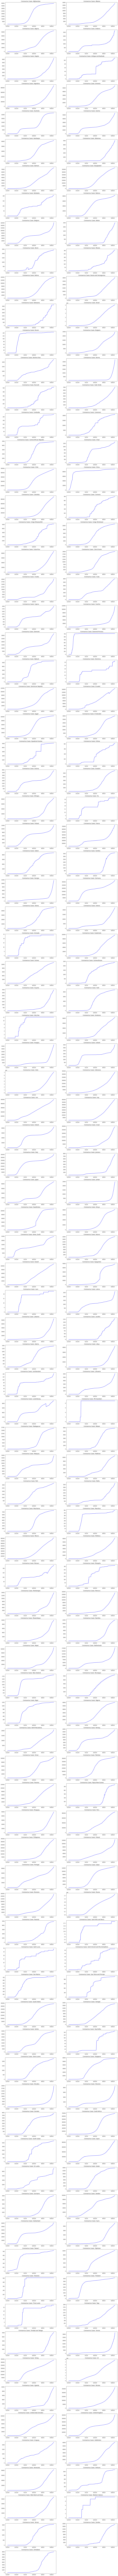

In [67]:
#countries = sorted(confirmed_df['Country/Region'].unique())
countries =["Brazil", "India", "Colombia", "US","Russia"]
n_rows = len(countries) // 2 + 1
i = 0
for country in (countries):
    country_data = confirmed_df[confirmed_df['Country/Region'] == country]
    # sum all the rows together for each column, and select only the data columns
    by_date = country_data.sum().filter(like='/20')
    
    # plot it if numbers exceed specified amount on date
    if by_date['10/10/20'] > 0:
        plt.subplot(n_rows, 2, i+1)
        by_date.plot(title='Coronavirus Cases: %s' % country, color='blue', figsize=(20,5 * n_rows))
        i += 1

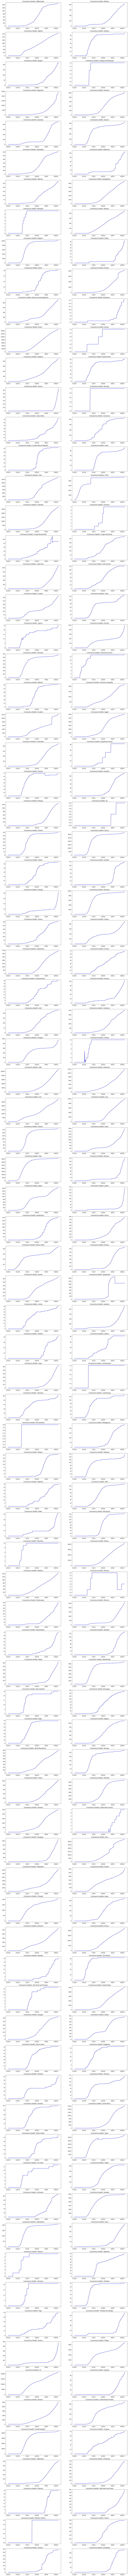

In [68]:
#countries = sorted(deaths_df['Country/Region'].unique())
countries =["Brazil", "India", "Colombia", "US","Russia"]
n_rows = len(countries) // 2 + 1
i = 0
for country in (countries):
    country_data = deaths_df[deaths_df['Country/Region'] == country]
    # sum all the rows together for each column, and select only the data columns
    by_date = country_data.sum().filter(like='/20')
    
    # plot it if numbers exceed specified amount on date
    if by_date['10/10/20'] > 0:
        plt.subplot(n_rows, 2, i+1)
        by_date.plot(title='Coronavirus Deaths: %s' % country, color='blue', figsize=(20,5 * n_rows))
        i += 1

# 2. Sorting the countries with most coronavirus cases
We first sort the data to understand the countries with most cases


In [69]:
date_list = confirmed_df.columns.tolist()[4:]
date_list[0], date_list[-1]

('1/22/20', '10/11/20')

In [119]:
# Confirmed cases per Country
confirmed_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(10)

Country/Region  10/11/20
242             US   7762546
143          India   7120538
30          Brazil   5094979
208         Russia   1291687
89        Colombia    911316
6        Argentina    894206
226          Spain    861112
202           Peru    849371
177         Mexico    817503
126         France    702148

In [114]:
confirmed_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = True).head(5)

Country/Region  10/11/20
85            China         1
246  United Kingdom         3
168      MS Zaandam         9
262  Western Sahara        10
139        Holy See        12

## Plotting the top five countries 


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:668: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


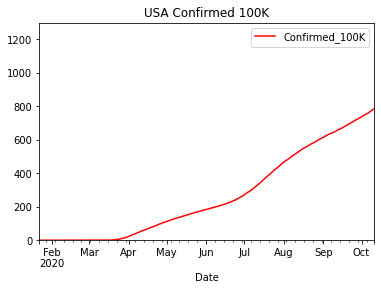

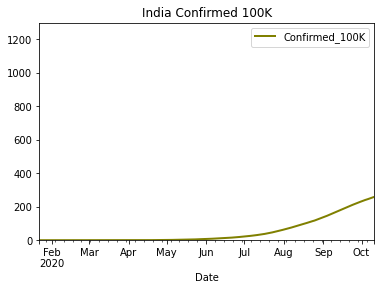

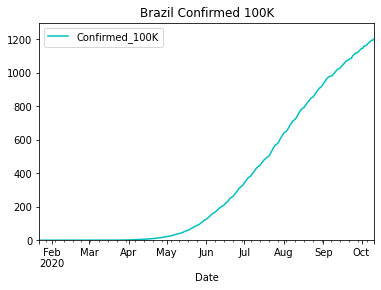

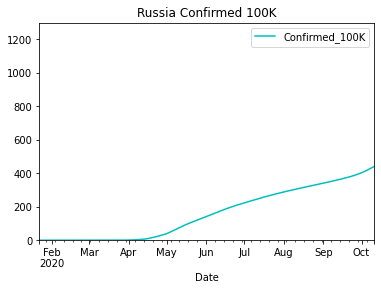

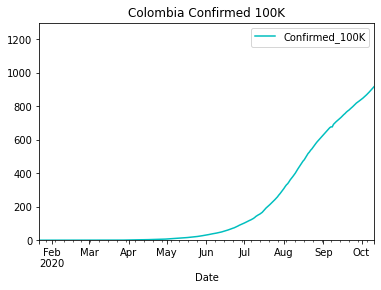

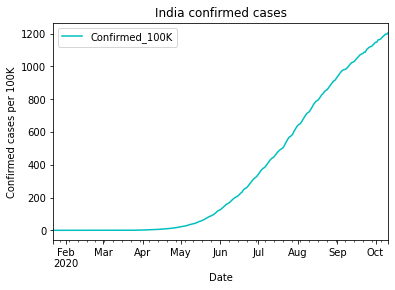

In [71]:
my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Confirmed_100K', color='red',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("USA Confirmed 100K")
my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Confirmed_100K',marker='', color='olive', linewidth=2)
plt.ylim(0 , 1300)
plt.title("India Confirmed 100K")
my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("Brazil Confirmed 100K")
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("Russia Confirmed 100K")
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("Colombia Confirmed 100K")

plt.legend()
plt.show()


India_covid_df = my_final_df[my_final_df['Country_Region'] == "Brazil"]
plot1=India_covid_df.plot(y='Confirmed_100K',kind="line",c='c')
#plt.ylim(0 , 100)
plt.title("India confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.show()

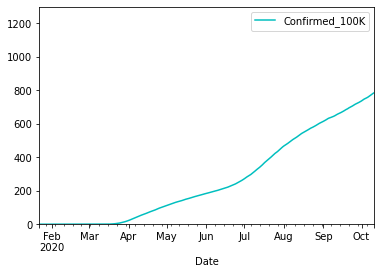

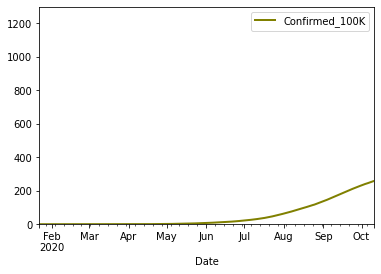

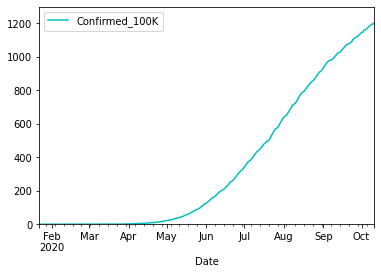

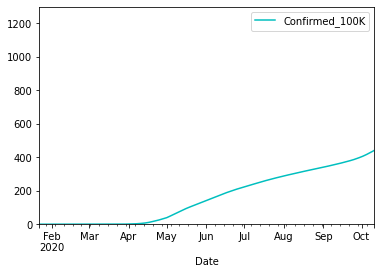

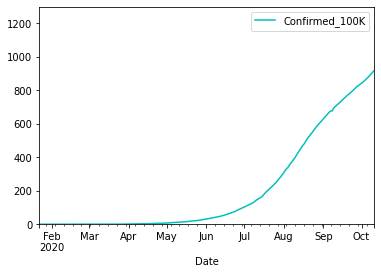

In [72]:
my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Confirmed_100K',marker='', color='olive', linewidth=2)
plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)


plt.legend()
plt.show()


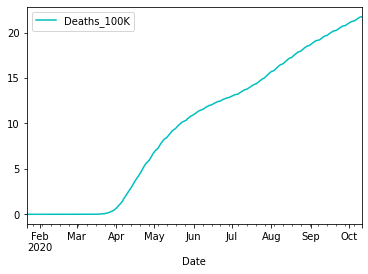

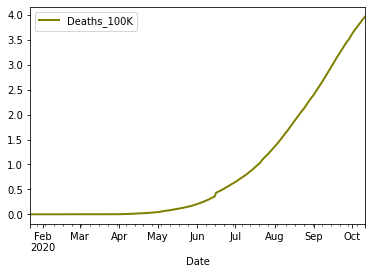

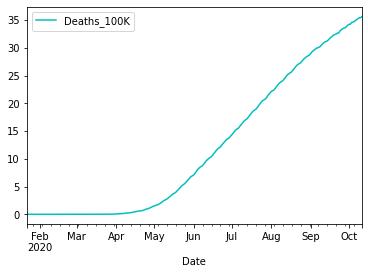

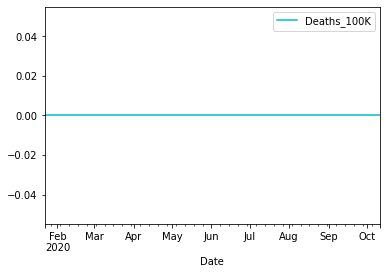

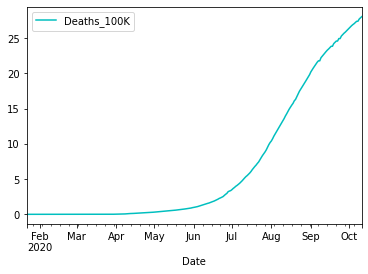

In [73]:
my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Deaths_100K',marker='', color='olive', linewidth=2)
#plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)

plt.legend()
plt.show()


In [74]:
my_final_df.describe()

StringencyIndex    Population  ...  New_recovered_100K    GDP_in_USD
count     45894.000000  4.752000e+04  ...        47520.000000  4.118400e+04
mean         52.167810  6.981179e+07  ...          106.974849  5.374090e+11
std          29.624243  3.034784e+08  ...         1436.595955  2.131238e+12
min           0.000000  3.483000e+03  ...        -9244.903819  5.960333e+08
25%          27.780000  2.941136e+06  ...            0.000000  1.562888e+10
50%          57.410000  9.897504e+06  ...            0.014651  5.698360e+10
75%          77.780000  3.301700e+07  ...            0.906513  2.873814e+11
max         100.000000  2.801206e+09  ...        96879.777753  2.137442e+13

[8 rows x 17 columns]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:668: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


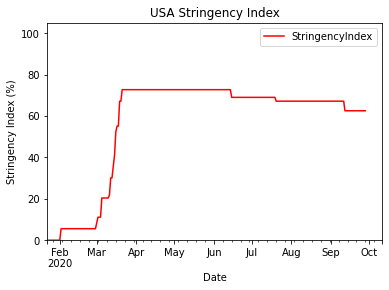

In [75]:
#A. USA Stringency 
my_complete_df[my_complete_df['CountryCode'] == "USA"].plot(y='StringencyIndex',color='red', kind="line",c='c')
#plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.ylim(0 , 105)
plt.title("USA Stringency Index")
plt.ylabel("Stringency Index (%)")
plt.legend()
plt.show()



In [113]:
countries = ["IND", "BRA", "RUS", "COL", "USA"]
coun = my_final_df[my_final_df['CountryCode'].isin(countries)].reset_index()
coun

Date CountryCode  ...    GDP_in_USD    incomeLevel.value
0    2020-01-22         BRA  ...  1.839758e+12  Upper middle income
1    2020-01-23         BRA  ...  1.839758e+12  Upper middle income
2    2020-01-24         BRA  ...  1.839758e+12  Upper middle income
3    2020-01-25         BRA  ...  1.839758e+12  Upper middle income
4    2020-01-26         BRA  ...  1.839758e+12  Upper middle income
...         ...         ...  ...           ...                  ...
1315 2020-10-07         USA  ...  2.137442e+13          High income
1316 2020-10-08         USA  ...  2.137442e+13          High income
1317 2020-10-09         USA  ...  2.137442e+13          High income
1318 2020-10-10         USA  ...  2.137442e+13          High income
1319 2020-10-11         USA  ...  2.137442e+13          High income

[1320 rows x 21 columns]

In [112]:
#countries = ["US", "India", "Brazil", "Russia", "Colombia"]
#coun= my_final_df[my_final_df['Country_Region'].isin(countries)].reset.index()
sb.relplot(
    data=coun, kind="line",
    x="Date", y="Death_100K",
    hue="CountryCode")

# col="align",
#my_complete_df[(my_complete_df['Country_Region'] == "Brazil") & (my_complete_df['Country_Region'] == "India") & (my_complete_df['Country_Region'] == "Colombia")]
#subset_df= my_complete_df.loc[:,[my_complete_df['Country_Region'] == "US"]].copy()

# plot1=subs.plot(y='StringencyIndex',kind="line",c='c')
#plt.show()

ValueError: ignored

In [ ]:
x.corr(y)

In [ ]:
#my_complete_df[my_complete_df['CountryCode'] == "USA"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
Bra_covid_df.plot(y='StringencyIndex',kind="line",c='c')

#ax1.plot(x, y1, 'g-')
#ax2.plot(x, y2, 'b-')


In [ ]:
#A. USA Stringency 
US_covid_df = my_complete_df[my_complete_df['CountryCode'] == "USA"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]
plot1=my_complete_df[my_complete_df['CountryCode'] == "USA"].plot(y='StringencyIndex',kind="line",c='c')
plt.show()
# B. India Stringency
India_covid_df = my_complete_df[my_complete_df['Country_Region'] == "India"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]
plot1=India_covid_df.plot(y='StringencyIndex',kind="line",c='c')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

#df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })

my_complete_df[my_complete_df['Country_Region'] == "India"].plot(y='StringencyIndex',marker='', color='olive', linewidth=2)
plt.ylim(0 , 105)
my_complete_df[my_complete_df['CountryCode'] == "USA"].plot(y='StringencyIndex',kind="line",c='c')
plt.ylim(0 , 105)
my_complete_df[my_complete_df['Country_Region'] == "Brazil"].plot(y='StringencyIndex')
plt.ylim(0 , 105)

# C. Brazil Stringency
Bra_covid_df = my_complete_df[my_complete_df['Country_Region'] == "Brazil"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]
plot1=Bra_covid_df.plot(y='StringencyIndex',kind="line",c='c')
plt.show()

plt.legend()
plt.show()

In [ ]:
my_complete_df[my_complete_df['Country_Region'] == "Brazil"].plot(y='StringencyIndex', color='green')
plt.title("Brazil Stringency Index")
plt.ylim(0 , 105)
plt.ylabel("Stringency Index (%)")
plt.legend()
plt.show()



In [ ]:
India_covid_df = my_final_df[my_final_df['Country_Region'] == "Brazil"]
plot1=India_covid_df.plot(y='Confirmed_100K',kind="line",c='c')
#plt.ylim(0 , 100)
plt.title("India confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.show()


In [ ]:
my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Confirmed_100K',kind="line",color='red',c='c')
plt.title("USA confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()

my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Confirmed_100K',marker='', color='olive', linewidth=2)
plt.title("India confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()

my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Confirmed',kind="line",color='green',c='c')
plt.title("Brazil confirmed cases")
plt.ylabel("Confirmed cases per 100K")
#plt.ylim(0 , 1300)
plt.legend()
plt.show()
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
plt.title("Russia confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Confirmed_100K',kind="line",color='purple',c='c')
plt.title("Colombia confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()

In [ ]:
#my_final_df[my_final_df['CountryCode'] == "USA"]
#my_final_df.describe
#my_final_df.columns
#my_final_df['Date'] 
#= pd.to_datetime(my_final_df['Date'], format='%Y%m%d')

#date_list= my_final_df.loc['2020-10-10']
#date_list
#my_final_df.set_index(my_final_df['Date'], inplace=True) 
#my_final_df[:,my_final_df["Date"]]
#confirmed_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(5)
date_list[['CountryCode', "Confirmed"]].sort_values(by ="Confirmed", ascending = False).head(5)

In [ ]:
my_final_df.columns

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

In [ ]:
my_final_df

In [ ]:
dates = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths')

recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [ ]:
confirmed_df_india = confirmed_df[confirmed_df["Country/Region"]=="India"]
deaths_df_india = deaths_df[deaths_df["Country/Region"]=="India"]
recovered_df_india= recovered_df[recovered_df["Country/Region"]=="India"]
recovered_df_india
#deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
#recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [ ]:
#world_confirmed_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

Predictive analysis


In [ ]:
# World Recovered
world_recovered_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
world_recovered_ts_df = pd.read_csv(world_recovered_ts_url, header=0, escapechar='\\')
world_recovered_ts_df.head(5)

In [ ]:
world_recovered_ts_df = world_recovered_ts_df.assign(days=[1 + 
                                               i for i in range(len(world_recovered_ts_df))])[['days'] + 
                                               world_recovered_ts_df.columns.tolist()]

In [ ]:
recovered_df_long = world_recovered_ts_df.melt(
    id_vars=["days",'Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [ ]:
training_set = recovered_df_long
x = np.array(training_set["days"]).reshape(-1, 1)
y = training_set["Recovered"]

In [ ]:
regression_model = PolynomialRegressionModel("Cases using Polynomial Regression", 2)
regression_model.train(x, y)

In [ ]:
y_pred = regression_model.get_predictions(x)
y_pred

In [ ]:
plot_graph("Cases using Polynomial Regression", x, y, y_pred)

In [ ]:
training_set = new_usa_recovered_df
x = np.array(training_set["days"]).reshape(-1, 1)
y = training_set["recovered"]

#3. Correlations

Here, we explored the correlations between the variables



In [83]:
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sb
model = LinearRegression()


In [118]:
#coun[coun["Confirmed"] = 1]
#coun[coun["Confirmed"]]
coun.isna().sum()

Date                   0
CountryCode            0
StringencyIndex       56
Country_Region         0
Population             0
Confirmed              0
Deaths                 0
Recovered              0
Active                 0
New_cases              0
New_deaths             0
New_recovered          0
Confirmed_100K         0
Deaths_100K            0
Recovered_100K         0
Active_100K            0
New_cases_100K         0
New_deaths_100K        0
New_recovered_100K     0
GDP_in_USD             0
incomeLevel.value      0
dtype: int64

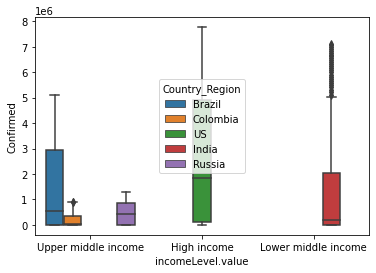

In [99]:
sb.boxplot(
    data=coun, x="incomeLevel.value", y="Confirmed",
    hue="Country_Region")

In [ ]:
# We explored the graphical correlation between the variables of interest

#col_stringe=stringe_natio_dataset[stringe_natio_dataset["CountryName"]=="Colombia"]
#col_stringe
#stringe_natio_dataset['Date'] = pd.to_datetime(stringe_natio_dataset['Date'], format = '%Y%m%d')
col_sub= my_final_df[my_final_df['Country_Region'] == "Colombia"]
ind_sub= my_final_df[my_final_df['Country_Region'] == "India"]
usa_sub= my_final_df[my_final_df['CountryCode'] == "USA"]
bra_sub = my_final_df[my_final_df['Country_Region'] == "Brazil"]
rus_sub= my_final_df[my_final_df['Country_Region'] == "Russia"]


In [ ]:
col_sub =col_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
ind_sub =ind_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
usa_sub =usa_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
bra_sub =bra_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
rus_sub =rus_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]

sb.pairplot(col_sub)
sb.pairplot(ind_sub)
sb.pairplot(usa_sub)
sb.pairplot(bra_sub)
sb.pairplot(rus_sub)
#col_sub["Confirmed_100K"]

In [ ]:
#spearmanr_coefficient, p_value=spearmanr(col_sub["Confirmed_100K"],col_sub["Deaths_100K"])
p_value1=spearmanr(col_sub["Confirmed_100K"],col_sub["Deaths_100K"])
p_value2=spearmanr(col_sub["Confirmed_100K"],col_sub["Recovered"])
p_value3=spearmanr(col_sub["Confirmed_100K"],col_sub["StringencyIndex"])
p_value3
#spearmanr_coefficient

In [ ]:

#training_set_deaths = my_col_death
y_deaths = np.array([my_col_death["StringencyIndex"]]).reshape(-1, 1)
x_deaths = np.array([my_col_death["Deaths"]]).reshape(-1, 1)
#len(y_deaths)
pearsonr(x_deaths, y_deaths)
len(y_deaths)

In [ ]:
import operator

def plot_graph(model_name, x, y, y_pred):

    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)

    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

# 4. Polynomial Regression of Coronavirus cases

This data could be potentially used for predictive analysis


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionModel:

    def __init__(self, model_name, polynomial_degree):
        self.__model_name = model_name
        self.__polynomial_degree = polynomial_degree
        self.__model = None

    def train(self, x, y):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        self.__model = LinearRegression()
        self.__model.fit(x_poly, y)

    def get_predictions(self, x):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        return np.round(self.__model.predict(x_poly), 0).astype(np.int32)

    def get_model_polynomial_str(self):
        coef = self.__model.coef_
        intercept = self.__model.intercept_
        poly = "{0:.3f}".format(intercept)

        for i in range(1, len(coef)):
            if coef[i] >= 0:
                poly += " + "
            else:
                poly += " - "
            poly += "{0:.3f}".format(coef[i]).replace("-", "") + "X^" + str(i)

        return poly

In [ ]:
def print_forecast(model_name, model, beginning_day=0, limit=10):

    next_days_x = np.array(range(beginning_day, beginning_day + limit)).reshape(-1, 1)
    next_days_pred = model.get_predictions(next_days_x)

    print("The forecast for " + model_name + " in the following " + str(limit) + " days is:")
    for i in range(0, limit):
        print("Day " + str(i + 1) + ": " + str(next_days_pred[i]))

In [ ]:
import operator

def plot_graph(model_name, x, y, y_pred):

    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)

    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

In [ ]:
# 1. Data, first example is Russia
overall_deaths_ts_df = deaths_df[deaths_df["Country/Region"] == "Colombia"]
new_country_deaths_df = overall_deaths_ts_df[date_list].T


new_country_deaths_df.columns = ["deaths"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
overall_deaths_ts_df = confirmed_df[confirmed_df["Country/Region"] == "India"]
new_country_deaths_df = overall_deaths_ts_df[date_list].T


new_country_deaths_df.columns = ["confirmed"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
# 2. select data attention
training_set_deaths = new_country_deaths_df
x_deaths = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_deaths = training_set_deaths["confirmed"]

In [ ]:
# 3 Modelling Country predictive deaths
regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)
y_deaths_pred = regression_model.get_predictions(x_deaths)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Russia Deaths", x_deaths, y_deaths, y_deaths_pred)

# Examples


In [ ]:
# 1. Data, first example is Russia 2
new_country_deaths_df= my_final_df[my_final_df['Country_Region'] == "Colombia"]
#overall_deaths_ts_df = deaths_df[deaths_df["Country/Region"] == "Russia"]
#new_country_deaths_df = overall_deaths_ts_df[date_list].T
#new_country_deaths_df.columns = ["deaths"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
# 2. select data attention
training_set_deaths = new_country_deaths_df
x_deaths = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_deaths = training_set_deaths["Deaths"]
x_active = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_active = training_set_deaths["Active"]
x_confirmed = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_confirmed = training_set_deaths["Confirmed"]


In [ ]:
# 3 Modelling Country predictive deaths, 
regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)
y_deaths_pred = regression_model.get_predictions(x_deaths)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Colombia Deaths", x_deaths, y_deaths, y_deaths_pred)

regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 3)
regression_model.train(x_active, y_active)
y_active_pred = regression_model.get_predictions(x_active)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_active), 
               limit=10)
plot_graph("Colombia Active", x_active, y_active, y_active_pred)

regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_confirmed, y_confirmed)
y_confirmed_pred = regression_model.get_predictions(x_confirmed)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_confirmed), 
               limit=10)
plot_graph("Colombia Confirmed", x_confirmed, y_confirmed, y_confirmed_pred)

In [ ]:
MORE CODE

In [ ]:
countries = ["US", "India", "Brazil", "Russia", "Colombia"]
my_final_df[my_final_df['Country_Region'].isin(countries)].plot(y='Confirmed_100K',kind="line",c='c')

df=pd.DataFrame({'y1': my_final_df[my_final_df['Country_Region'] == "Brazil",],
                 'y2': np.random.randn(10)+range(1,11), 
                 'y3': np.random.randn(10)+range(11,21) })

# multiple line plot
#plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
#plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
#plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")



In [ ]:
usa_overall_deaths_ts_df = world_deaths_ts_df[world_deaths_ts_df["Country/Region"] == "Russia"]
new_usa_deaths_df = usa_overall_deaths_ts_df[date_list].T
new_usa_deaths_df.columns = ["deaths"]
new_usa_deaths_df = new_usa_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_usa_deaths_df))])[['days'] + 
                                                   new_usa_deaths_df.columns.tolist()]
new_usa_deaths_df

In [ ]:
x_deaths

In [ ]:
y_pred = regression_model.get_predictions(x)
y_pred

In [ ]:
print_forecast("Cases using Polynomial Regression", regression_model, 
               beginning_day=len(x), 
               limit=10)

In [ ]:
plot_graph("Cases using Polynomial Regression", x, y, y_pred)


In [ ]:
# Model
regression_model = PolynomialRegressionModel("Cases using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)

In [ ]:
# For Colombia
deaths_df
overall_deaths_ts_df = deaths_df[deaths_df["Country/Region"] == "Colombia"]
new_country_deaths_df = overall_deaths_ts_df[date_list].T
new_country_deaths_df.columns = ["deaths"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
#countries = sorted(corona_data['Country/Region'].unique())
countries =["Brazil", "India"]
n_rows = len(countries) // 2 + 1
i = 0
for country in (countries):
    country_data = my_final_df[my_final_df['Country_Region'] == country]
    # sum all the rows together for each column, and select only the data columns
    by_date = country_data[my_final_df['Confirmed_100K'].filter(like='/20')

#my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
    # plot it if numbers exceed specified amount on date
    if by_date['3/14/20'] > 1000:
        plt.subplot(n_rows, 2, i+1)
        by_date.plot(title='cases by date: %s' % country, color='green', figsize=(20,5 * n_rows))
        i += 1